In [5]:
import pandas as pd
import umap
import glob
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.cm as cm

from sklearn.neighbors import NearestNeighbors

from matplotlib import cm

In [6]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_left"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
lab = "Sex"
model_path = glob.glob(f"{path}/*")[0]
ukb_emb_file = f"{model_path}/ukb40_random_embeddings/full_embeddings.csv"
print(ukb_emb_file)

/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/FColl-SRh_left/11-53-20_94_0/ukb40_random_embeddings/full_embeddings.csv


In [7]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,9.855339,45.631443,10.060020,51.771660,8.478070,4.988151,-8.140727,-10.911059,43.815570,-10.105584,...,33.118095,-15.624771,-27.941100,2.852160,46.157475,24.440798,24.746952,132.67224,-39.249332,-10.191565
sub-1000325,36.622623,-10.259095,7.265591,30.991932,-14.519362,-15.731174,-31.460690,4.107340,-55.111850,38.218185,...,-52.196083,-7.545823,-16.506243,39.789757,38.814830,25.683529,27.407000,119.90040,-64.905846,-65.995575
sub-1000458,-34.563812,-28.634380,2.802658,20.492140,-11.130139,-8.628111,-3.044661,-22.876516,9.188710,37.231148,...,45.947090,0.169109,9.217993,65.817444,12.340383,-59.395767,6.378770,106.78734,7.183937,3.183411
sub-1000575,-7.034242,-41.465206,-8.991343,63.184370,-0.292778,-26.021795,-15.396147,-12.797480,0.084663,41.402267,...,-45.141834,8.213155,2.001921,40.315105,-7.051990,-47.676765,19.328588,123.70115,28.073114,-29.807207
sub-1000606,-66.415245,-18.612453,-2.978323,27.743166,11.945621,-56.238567,-2.480288,4.316528,12.236313,-1.701040,...,-36.500490,-10.481411,-12.624851,7.911556,-35.915565,-10.178987,26.869083,148.25537,79.333950,2.007291


In [8]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[[lab]].dropna()
participants.head()

,Sex
participant_id,
sub-3411469,1
sub-2290292,0
sub-3842391,0
sub-2758537,1
sub-4334619,1


In [9]:
merged = participants[[lab]].merge(ukb_emb, left_index=True, right_index=True)
# UKB latent space analysis

In [10]:
embeddings = merged.iloc[:,1:]
label = merged.iloc[:,0:1]
label_random = label.copy()
label_random[:] = label_random.sample(frac=1).values
# print(embeddings.head())
print(label.head())
print(label_random.head())

             Sex
sub-3411469    1
sub-2290292    0
sub-3842391    0
sub-2758537    1
sub-4334619    1
             Sex
sub-3411469    0
sub-2290292    0
sub-3842391    0
sub-2758537    0
sub-4334619    1


In [11]:
# Construct nearest_neighbor matrix
nbrs = NearestNeighbors(n_neighbors=int(len(embeddings)/2), algorithm='brute').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)
indices.shape

(37715, 18857)

In [8]:
def construct_average_nearest_neighbors(label):
    # Takes list of incides whose label is 1
    label_red = label.reset_index()[[lab]]
    label_1 = label_red[label_red[lab]==1].index.to_list()
    
    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.in1d(neighbors, label_1)
    labels1 = labels1.reshape(neighbors.shape).astype(int)
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [9]:
def construct_average_distance_nearest_neighbors():

    # Makes moving average along nearest neighbor
    distances_cum = np.cumsum(distances[:,1:], axis=1)
    means_distance = np.zeros(distances_cum.shape)
    for idx in range(len(distances)):
        means_distance[idx,:] = distances_cum[idx,:]/(np.arange(1, distances_cum.shape[1]+1, 1).reshape(1,-1))
        
    return means_distance

In [10]:
values_npy, means_npy = construct_average_nearest_neighbors(label)

In [11]:
means_distance = construct_average_distance_nearest_neighbors()

In [12]:
val_random_npy, random_npy = construct_average_nearest_neighbors(label_random)

In [13]:
def create_mean_interval(values_npy):
    i=0
    limits = [0]
    while (i<values_npy.shape[1]):
        j = min(2*i+1, values_npy.shape[1])
        limits.append(j)
        i = j
    limits = limits[:-1]
    print(limits)
    means_interval = np.zeros((values_npy.shape[0], (len(limits)-1)))
    for i in range(len(limits)-1):
        means_interval[:,i] = np.mean(values_npy[:, limits[i]:limits[i+1]], axis=1)
    return means_interval, limits

In [14]:
means_interval, limits = create_mean_interval(values_npy)

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191, 16383]


In [15]:
means_distance_interval, _ = create_mean_interval(distances[:,1:])

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191, 16383]


In [16]:
means_distance_interval.shape

(37715, 14)

In [17]:
means_random_interval, _ = create_mean_interval(val_random_npy)

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191, 16383]


In [18]:
print(len(limits), means_interval.shape[1])

15 14


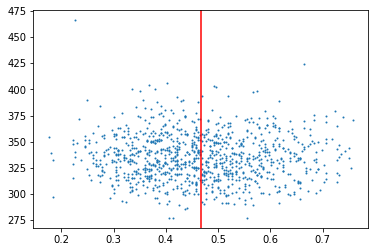

In [19]:
nb_interval=8
number=1000
plt.scatter(means_interval[:number, nb_interval], means_distance_interval[:number, nb_interval], s=1)
plt.axvline(x=np.mean(label.values), color='r', linestyle='-')
# plt.axhline(y=0, color='black', linestyle='-')
# plt.axhline(y=1, color='black', linestyle='-')

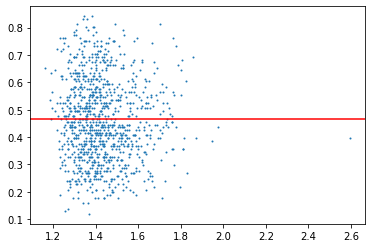

In [20]:
nb_interval=100
number=1000
plt.scatter(means_distance[:number, nb_interval]/means_distance[:number, 1], means_npy[:number, nb_interval], s=1)
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')

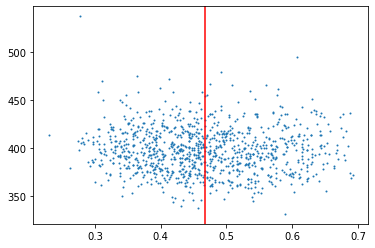

In [21]:
nb_interval=10
number=1000
plt.scatter(means_interval[:number, nb_interval], means_distance_interval[:number, nb_interval], s=1)
plt.axvline(x=np.mean(label.values), color='r', linestyle='-')
# plt.axhline(y=0, color='black', linestyle='-')
# plt.axhline(y=1, color='black', linestyle='-')

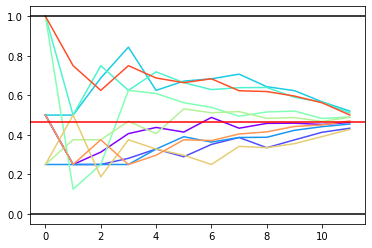

In [22]:
number=10
for idx in range(number):
    idx2 = (idx+1000)
    plt.plot(means_interval[idx2, 2:], c = cm.rainbow(1.*idx/number))
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')

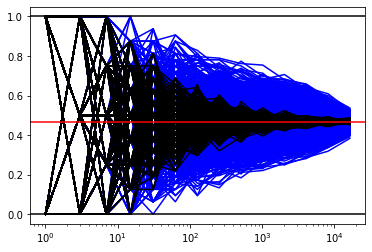

In [23]:
for idx in range(1,35000,50):
    plt.plot(limits[1:], means_interval[idx, :], color='b')
for idx in range(1,35000,50):
    plt.plot(limits[1:], means_random_interval[idx, :], color='black')
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.xscale('log')

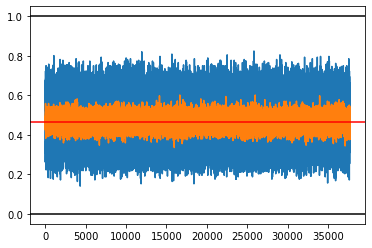

In [24]:
nb_interval=8
plt.plot(means_interval[:, nb_interval])
plt.plot(means_random_interval[:, nb_interval])
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

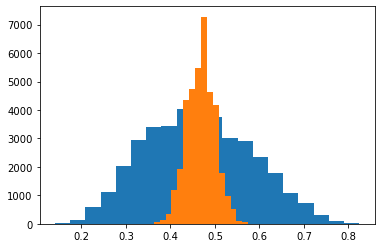

In [25]:
nb_interval=8
plt.hist(means_interval[:, nb_interval], bins=20)
plt.hist(means_random_interval[:, nb_interval], bins=20)
plt.show()

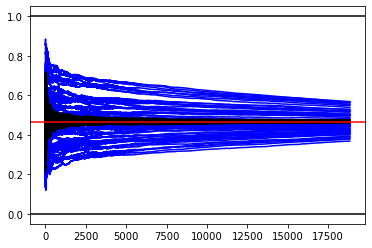

In [26]:
for idx in range(1,35000,500):
    plt.plot(means_npy[idx, 20:], color='b')
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

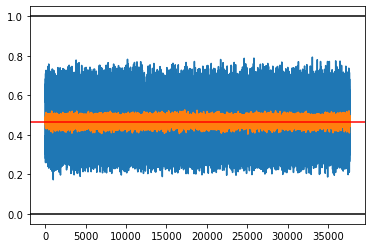

In [27]:
plt.plot(means_npy[:, 1000])
plt.plot(random_npy[:, 1000])
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()